<a href="https://colab.research.google.com/github/liverishav13/EE798R_Code/blob/main/Code_EE798R.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
from transformers import CLIPModel, CLIPTokenizer
from diffusers import StableDiffusionPipeline
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt

In [ ]:
# Define the Context Diffusion model
class ContextDiffusion(nn.Module):
    def __init__(self, text_encoder, image_encoder, diffusion_model, tokenizer):
        super(ContextDiffusion, self).__init__()
        self.text_encoder = text_encoder
        self.image_encoder = image_encoder
        self.diffusion_model = diffusion_model
        self.tokenizer = tokenizer

        # Add a linear layer to project image embeddings to match text embeddings
        self.image_projection = nn.Linear(768, 512)

    def forward(self, query_image, context_images, prompt=None):
        # Encode the text prompt if available
        if prompt:
            # Tokenize the prompt
            inputs = self.tokenizer(prompt, return_tensors="pt")
            text_embeddings = self.text_encoder(**inputs).last_hidden_state
        else:
            text_embeddings = torch.zeros([1, 512])  # Dummy embedding if no prompt provided

        # Stack context images to form a batch and process as a single input
        context_images = torch.cat(context_images, dim=0)  # Batch all context images together
        context_embeddings = self.image_encoder(pixel_values=context_images).last_hidden_state
        context_embeddings = context_embeddings.mean(dim=0, keepdim=True)  # Aggregate by averaging

        # Project image embeddings to match the dimension of text embeddings
        context_embeddings = self.image_projection(context_embeddings)

        # Combine text and context embeddings
        combined_embeddings = torch.cat([text_embeddings, context_embeddings], dim=1)

        # Generate an image conditioned on the embeddings
        generated_image = self.diffusion_model(prompt, num_inference_steps=50).images[0]

        return generated_image

In [ ]:
def calculate_mean_std(image):
    # Calculate the mean and standard deviation per channel
    mean = torch.mean(image, dim=[1, 2])  # Mean across width and height
    std = torch.std(image, dim=[1, 2])    # Standard deviation across width and height
    return mean, std

def load_image_as_tensor(image_path):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),  # Resize to 224x224 for CLIP
        transforms.ToTensor()
    ])
    image = Image.open(image_path).convert("RGB")
    image = transform(image)

    # Calculate dynamic mean and std for normalization
    mean, std = calculate_mean_std(image)

    # Normalize the image using dynamic mean and std
    normalize = transforms.Normalize(mean.tolist(), std.tolist())
    normalized_image = normalize(image)

    return normalized_image.unsqueeze(0)  # Add batch dimension

# Initialize encoders and tokenizer
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
text_encoder = clip_model.text_model
image_encoder = clip_model.vision_model
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-base-patch32")

# Load the Stable Diffusion model from diffusers
diffusion_model = StableDiffusionPipeline.from_pretrained("CompVis/stable-diffusion-v1-4").to("cpu")

# Instantiate Context Diffusion Model
model = ContextDiffusion(text_encoder, image_encoder, diffusion_model, tokenizer)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

safety_checker/config.json:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

(…)kpoints/scheduler_config-checkpoint.json:   0%|          | 0.00/209 [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/313 [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

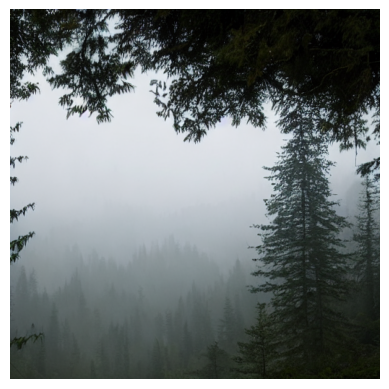

In [ ]:
# Load example images
query_image = load_image_as_tensor("/content/img1.jpg").to("cpu")
context_images = [
    load_image_as_tensor("/content/img2.jpg").to("cpu"),
    load_image_as_tensor("/content/img3.jpg").to("cpu"),
    load_image_as_tensor("/content/img4.jpg").to("cpu")
]

# text prompt
prompt = "A forest with misty mountains."

# Run forward pass
generated_image = model(query_image, context_images, prompt)

# Display the generated image
plt.imshow(generated_image)
plt.axis('off')
plt.show()